In [1]:
!pip install openml
!pip install seaborn

Looking in indexes: https://pypi.org/simple, http://xdrd1006s.priv.atos.fr:1616/
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, http://xdrd1006s.priv.atos.fr:1616/
You are using pip version 19.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import openml
import pandas as pd
from pprint import pprint
import numpy as np
import random
from collections import OrderedDict
import arff
from sklearn.metrics import roc_auc_score
from scipy.stats.stats import pearsonr,spearmanr

In [3]:
from calibrated_metrics import average_precision, f1score, bestf1score
import prg
import prgc
import seaborn as sns
import matplotlib.pylab as plt

/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Experiments with synthetic data 

In [4]:
n_samples_exp = 1000000
exact_ratio = True #need less samples
n_runs_exp = 5

In [5]:
# creates synthetic dataset based on a gaussian distribution
def make_classification_gaussian(n_samples,mu1=2,sig1=1,mu0=0,sig0=1,ratio=0.5,exact=True):
    

    sig1 = sig1
    mu1 = mu1
    sig0 = sig0
    mu0 = mu0
    
    if exact:
        y_true = np.zeros(n_samples)
        n_pos = int(ratio*n_samples)
        y_true[0:n_pos] = 1
        y_true = np.random.permutation(y_true)
    else:
        ytrue = np.random.binomial(1, ratio, size=n_samples)
    y_score = np.zeros(y_true.shape)
    num_1 = np.sum(y_true)
    x_tmp_1 = np.random.normal(mu1,sig1,int(num_1))
    y_score_1 = np.exp(-(x_tmp_1-mu1)**2/(2*sig1**2))/np.exp(-(x_tmp_1-mu0)**2/(2*sig0**2))
    x_tmp_0 = np.random.normal(mu0,sig0,n_samples-int(num_1))
    y_score_0 = np.exp(-(x_tmp_0-mu1)**2/(2*sig1**2))/np.exp(-(x_tmp_0-mu0)**2/(2*sig0**2))
    y_score[y_true==1] = y_score_1
    y_score[y_true == 0] = y_score_0
    
    return y_score,y_true
    

## Invariance w.r.t. prior

In [6]:
ratioss = []

ratios = list(np.arange(0.001,0.01,0.001))

ratios = ratios + list(np.arange(ratios[-1]+0.01,0.05,0.01))

ratios = ratios + list(np.arange(ratios[-1]+0.1,0.5,0.1))+[0.5]

# ratios = ratios[::-1]

mu0=1.8

sig0=1

mu1=2

sig1=1

In [7]:
ratios

[0.001,
 0.002,
 0.003,
 0.004,
 0.005,
 0.006,
 0.007,
 0.008,
 0.009000000000000001,
 0.019000000000000003,
 0.029000000000000005,
 0.03900000000000001,
 0.04900000000000001,
 0.14900000000000002,
 0.24900000000000003,
 0.34900000000000003,
 0.44900000000000007,
 0.5]

In [8]:
metrics = {}
metrics["AUC-PR"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-P$_c$R"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-PR Gain"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-P$_c$R Gain"] = np.zeros((n_runs_exp,len(ratios)))
metrics["F1 score"] = np.zeros((n_runs_exp,len(ratios)))
metrics["F1 score$_c$"] = np.zeros((n_runs_exp,len(ratios)))

for i in range(n_runs_exp):
    print("#Run:",i+1)
    for (j,ratio) in enumerate(ratios):
        print("Ratio:",ratio)  
        y_score,y_true = make_classification_gaussian(n_samples_exp,mu0=mu0,sig0=sig0,mu1=mu1,sig1=sig1,ratio=ratio,exact=exact_ratio)
        metrics["AUC-PR"][i,j] = average_precision(y_true,y_score)
        metrics["AUC-P$_c$R"][i,j] = average_precision(y_true,y_score,pi0=0.5)
        metrics["AUC-PR Gain"][i,j] = prg.calc_auprg(prg.create_prg_curve(y_true,y_score))
        metrics["AUC-P$_c$R Gain"][i,j] = prgc.calc_auprg(prgc.create_prg_curve(y_true,y_score,pi0=0.5))
        metrics["F1 score"][i,j] = f1score(y_true,(y_score>0.5)*1)
        metrics["F1 score$_c$"][i,j] = f1score(y_true,(y_score>0.5)*1,pi0=0.5)     

#Run: 1
Ratio: 0.001
Ratio: 0.002
Ratio: 0.003
Ratio: 0.004
Ratio: 0.005
Ratio: 0.006
Ratio: 0.007
Ratio: 0.008
Ratio: 0.009000000000000001
Ratio: 0.019000000000000003
Ratio: 0.029000000000000005
Ratio: 0.03900000000000001
Ratio: 0.04900000000000001
Ratio: 0.14900000000000002
Ratio: 0.24900000000000003
Ratio: 0.34900000000000003
Ratio: 0.44900000000000007
Ratio: 0.5
#Run: 2
Ratio: 0.001
Ratio: 0.002
Ratio: 0.003
Ratio: 0.004
Ratio: 0.005
Ratio: 0.006
Ratio: 0.007
Ratio: 0.008
Ratio: 0.009000000000000001
Ratio: 0.019000000000000003
Ratio: 0.029000000000000005
Ratio: 0.03900000000000001
Ratio: 0.04900000000000001
Ratio: 0.14900000000000002
Ratio: 0.24900000000000003
Ratio: 0.34900000000000003
Ratio: 0.44900000000000007
Ratio: 0.5
#Run: 3
Ratio: 0.001
Ratio: 0.002
Ratio: 0.003
Ratio: 0.004
Ratio: 0.005
Ratio: 0.006
Ratio: 0.007
Ratio: 0.008
Ratio: 0.009000000000000001
Ratio: 0.019000000000000003
Ratio: 0.029000000000000005
Ratio: 0.03900000000000001
Ratio: 0.04900000000000001
Ratio: 0.149

(0, 1)

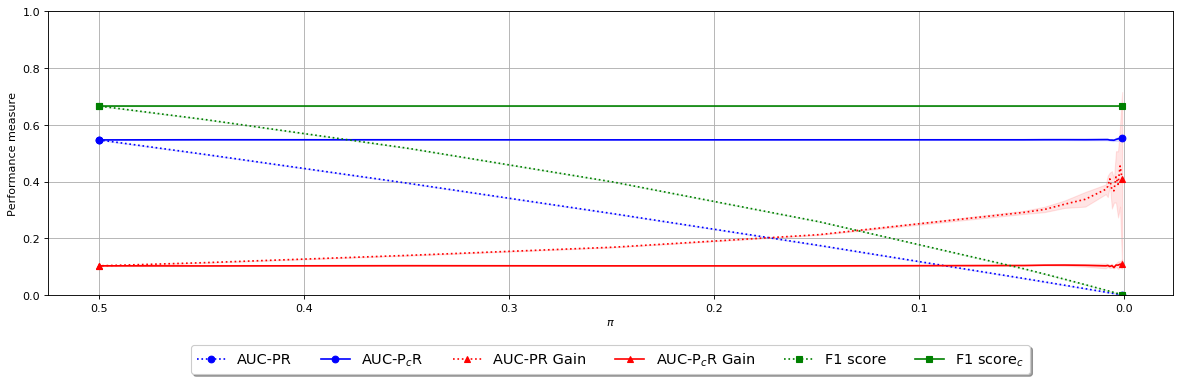

In [9]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

markers = ["o:","o-","^:","^-","s:","s-"]
colors = ["b","b","r","r","g","g"]

index = 0
for key in metrics:    
    plt.plot(ratios,metrics[key].mean(axis=0),markers[index],label=key,color=colors[index],markevery=len(ratios)-1) 
    plt.fill_between(ratios,metrics[key].mean(axis=0) - metrics[key].std(axis=0),metrics[key].mean(axis=0) + metrics[key].std(axis=0),alpha=0.1,color=colors[index])
    index +=1

#plt.xscale('log')
plt.grid()
plt.xlabel(r'$\pi$')
plt.ylabel("Performance measure")
plt.gca().invert_xaxis()
plt.rcParams.update({'font.size': 13})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=6)
plt.tight_layout()
plt.savefig("synthetic_data_invariance_prior.pdf")
plt.ylim([0, 1])

## Assessment of the model quality

In [10]:
ratioss = []

sig0=1

mu1=2

sig1=1

ratio = 0.5

mus = list(np.arange(0,2,0.05))

In [11]:
metrics = {}
metrics["AUC-PR"] = np.zeros((n_runs_exp,len(mus)))
metrics["AUC-P$_c$R"] = np.zeros((n_runs_exp,len(mus)))
metrics["AUC-PR Gain"] = np.zeros((n_runs_exp,len(mus)))
metrics["AUC-P$_c$R Gain"] = np.zeros((n_runs_exp,len(mus)))
metrics["F1 score"] = np.zeros((n_runs_exp,len(mus)))
metrics["F1 score$_c$"] = np.zeros((n_runs_exp,len(mus)))

for i in range(n_runs_exp):
    print("#Run:",i+1)
    
    dist = []
    
    for (j,mu0) in enumerate(mus):
        print("mu0:",mu0)
        ratio = (np.random.rand(1)/2.)[0]
        if ratio < 0.001:
            ratio = 0.001
        y_score,y_true = make_classification_gaussian(n_samples_exp,mu0=mu0,sig0=sig0,mu1=mu1,sig1=sig1,ratio=ratio,exact=exact_ratio)
        
        metrics["AUC-PR"][i,j] = average_precision(y_true,y_score)
        metrics["AUC-P$_c$R"][i,j] = average_precision(y_true,y_score,pi0=0.5)
        metrics["AUC-PR Gain"][i,j] = prg.calc_auprg(prg.create_prg_curve(y_true,y_score))
        metrics["AUC-P$_c$R Gain"][i,j] = prgc.calc_auprg(prgc.create_prg_curve(y_true,y_score,pi0=0.5))
        metrics["F1 score"][i,j] = f1score(y_true,(y_score>0.5)*1)
        metrics["F1 score$_c$"][i,j] = f1score(y_true,(y_score>0.5)*1,pi0=0.5)     
        
        dist.append((mu1-mu0)**2)

#Run: 1
mu0: 0.0
mu0: 0.05
mu0: 0.1
mu0: 0.15000000000000002
mu0: 0.2
mu0: 0.25
mu0: 0.30000000000000004
mu0: 0.35000000000000003
mu0: 0.4
mu0: 0.45
mu0: 0.5
mu0: 0.55
mu0: 0.6000000000000001
mu0: 0.65
mu0: 0.7000000000000001
mu0: 0.75
mu0: 0.8
mu0: 0.8500000000000001
mu0: 0.9
mu0: 0.9500000000000001
mu0: 1.0
mu0: 1.05
mu0: 1.1
mu0: 1.1500000000000001
mu0: 1.2000000000000002
mu0: 1.25
mu0: 1.3
mu0: 1.35
mu0: 1.4000000000000001
mu0: 1.4500000000000002
mu0: 1.5
mu0: 1.55
mu0: 1.6
mu0: 1.6500000000000001
mu0: 1.7000000000000002
mu0: 1.75
mu0: 1.8
mu0: 1.85
mu0: 1.9000000000000001
mu0: 1.9500000000000002
#Run: 2
mu0: 0.0
mu0: 0.05
mu0: 0.1
mu0: 0.15000000000000002
mu0: 0.2
mu0: 0.25
mu0: 0.30000000000000004
mu0: 0.35000000000000003
mu0: 0.4
mu0: 0.45
mu0: 0.5
mu0: 0.55
mu0: 0.6000000000000001
mu0: 0.65
mu0: 0.7000000000000001
mu0: 0.75
mu0: 0.8
mu0: 0.8500000000000001
mu0: 0.9
mu0: 0.9500000000000001
mu0: 1.0
mu0: 1.05
mu0: 1.1
mu0: 1.1500000000000001
mu0: 1.2000000000000002
mu0: 1.25
mu0:

In [12]:
metrics["AUC-PR"].mean(axis=0)

array([0.70516785, 0.69609721, 0.75056904, 0.80695286, 0.77423985,
       0.69822277, 0.60054292, 0.56048363, 0.7057898 , 0.57714922,
       0.66232878, 0.61400243, 0.64168911, 0.72595153, 0.68186947,
       0.61234773, 0.56836234, 0.52975794, 0.562019  , 0.51795424,
       0.42868818, 0.35809866, 0.26900454, 0.5295657 , 0.38307391,
       0.38951929, 0.30448026, 0.32148081, 0.43983721, 0.42859568,
       0.36110246, 0.25831197, 0.26458654, 0.29608821, 0.24417904,
       0.27507573, 0.26216388, 0.36035597, 0.26438775, 0.21382027])

(0, 1)

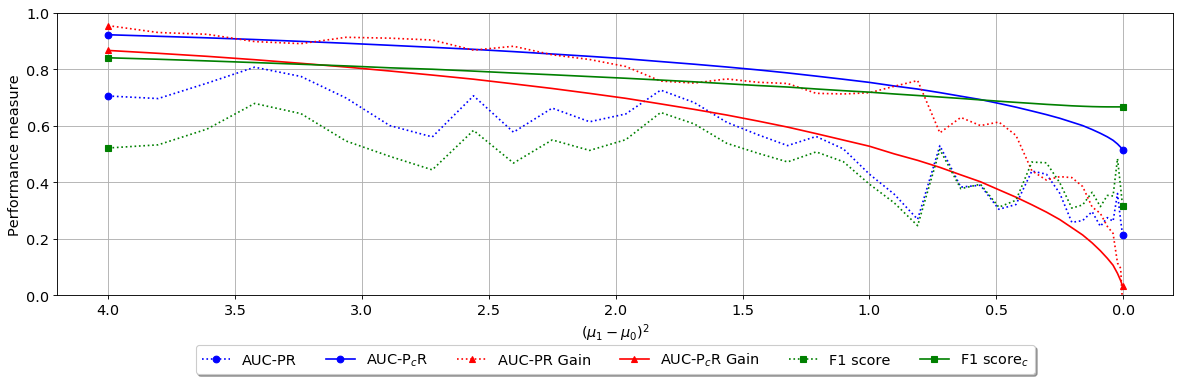

In [13]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

markers = ["o:","o-","^:","^-","s:","s-"]
colors = ["b","b","r","r","g","g"]

index = 0
for key in metrics:    
    plt.plot(dist,metrics[key].mean(axis=0),markers[index],label=key,color=colors[index],markevery=len(dist)-1) 
    index +=1

#plt.xscale('log')
plt.grid()
plt.xlabel(r'$(\mu_1-\mu_0)^2$')
plt.ylabel("Performance measure")
plt.gca().invert_xaxis()
plt.rcParams.update({'font.size': 13})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=6)
plt.tight_layout()
plt.savefig("synthetic_data_model_quality.pdf")
plt.ylim([0, 1])

# Experiment with real data

In [14]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
from sklearn.preprocessing import StandardScaler

data['normAmount'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1, 1))
data = data.drop(['Time','Amount'],axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [16]:
X = data.ix[:, data.columns != 'Class'].values
y = data.ix[:, data.columns == 'Class'].values

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

In [18]:
from sklearn.linear_model import LogisticRegression

In [19]:
lr = LogisticRegression()
lr.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [20]:
ratios = np.geomspace(np.sum(y_test)/len(y_test),0.5,20)

In [21]:
n_runs_exp = 10

In [22]:
y_pred = lr.predict_proba(X_test)

In [23]:
metrics = {}
metrics["AUC-PR"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-P$_c$R"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-PR Gain"] = np.zeros((n_runs_exp,len(ratios)))
metrics["AUC-P$_c$R Gain"] = np.zeros((n_runs_exp,len(ratios)))
metrics["F1 score"] = np.zeros((n_runs_exp,len(ratios)))
metrics["F1 score$_c$"] = np.zeros((n_runs_exp,len(ratios)))

for (j,pi) in enumerate(ratios):
    print("pi = ", pi)
    n_positive = np.sum(y_test)
    n_negative_sample = int(np.floor(n_positive*(1-pi)/pi))
    index_positive = np.where(y_test==1)[0]
    index_negative = np.where(y_test==0)[0]        
    for i in range(n_runs_exp):
        np.random.shuffle(index_negative)
        index_sample_negative = index_negative[:n_negative_sample]
        tot_index = np.concatenate([index_positive,index_sample_negative])
        
        y_true = y_test[tot_index]
        y_score = y_pred[tot_index,1]
                        
        metrics["AUC-PR"][i,j] = average_precision(y_true,y_score)
        metrics["AUC-P$_c$R"][i,j] = average_precision(y_true,y_score,pi0=0.5)
        metrics["AUC-PR Gain"][i,j] = prg.calc_auprg(prg.create_prg_curve(y_true,y_score))
        metrics["AUC-P$_c$R Gain"][i,j] = prgc.calc_auprg(prgc.create_prg_curve(y_true,y_score,pi0=0.5))
        metrics["F1 score"][i,j] = f1score(y_true,(y_score>0.5)*1)
        metrics["F1 score$_c$"][i,j] = f1score(y_true,(y_score>0.5)*1,pi0=0.5)  

pi =  0.001720445209086759
pi =  0.0023189412675594947
pi =  0.0031256378139731026
pi =  0.004212962130955698
pi =  0.005678536981322659
pi =  0.007653945429823789
pi =  0.010316544707801691
pi =  0.01390538979979654
pi =  0.018742696412497584
pi =  0.02526277032638019
pi =  0.0340510004813331
pi =  0.04589641669540062
pi =  0.061862530783277
pi =  0.08338282137166066
pi =  0.11238943528281514
pi =  0.1514866606262753
pi =  0.20418474645729617
pi =  0.2752150619300071
pi =  0.37095489074145327
pi =  0.5


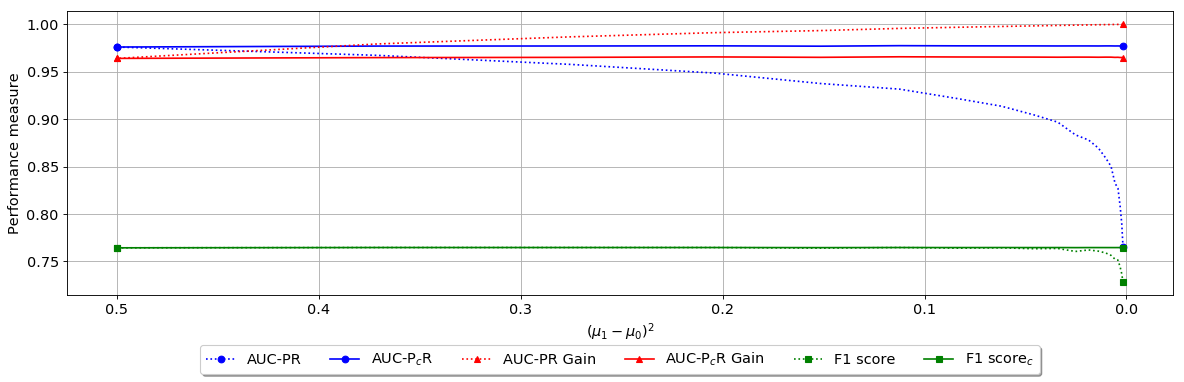

In [24]:
plt.figure(num=None, figsize=(15, 5), dpi=80, facecolor='w', edgecolor='k')

markers = ["o:","o-","^:","^-","s:","s-"]
colors = ["b","b","r","r","g","g"]

index = 0
for key in metrics:    
    plt.plot(ratios,metrics[key].mean(axis=0),markers[index],label=key,color=colors[index],markevery=len(ratios)-1) 
    index +=1

#plt.xscale('log')
plt.grid()
plt.xlabel(r'$(\mu_1-\mu_0)^2$')
plt.ylabel("Performance measure")
plt.gca().invert_xaxis()
plt.rcParams.update({'font.size': 13})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=6)
plt.tight_layout()
plt.savefig("real_data_invariance_ratio.pdf")

# Comparison between proposed formula and heuristic

In [25]:
pi0s = np.geomspace(np.sum(y_test)/len(y_test),0.5,20)

In [26]:
formula = []
heuristic_mean = []
heuristic_std = []
n_run_heuristic = 1000
for pi0 in pi0s:
    print("pi0 = ", pi0)
    formula.append(average_precision(y_test,y_pred[:,1],pi0=pi0))
    estim = []
    n_positive = np.sum(y_test)
    n_negative_sample = int(np.floor(n_positive*(1-pi0)/pi0))
    for i in range(n_run_heuristic):
        index_positive = np.where(y_test==1)[0]
        index_negative = np.where(y_test==0)[0]        
        np.random.shuffle(index_negative)
        index_sample_negative = index_negative[:n_negative_sample]
        tot_index = np.concatenate([index_positive,index_sample_negative])
        estim.append(average_precision(y_test[tot_index],y_pred[tot_index,1]))
    heuristic_mean.append(np.mean(estim))
    heuristic_std.append(np.std(estim))

pi0 =  0.001720445209086759
pi0 =  0.0023189412675594947
pi0 =  0.0031256378139731026
pi0 =  0.004212962130955698
pi0 =  0.005678536981322659
pi0 =  0.007653945429823789
pi0 =  0.010316544707801691
pi0 =  0.01390538979979654
pi0 =  0.018742696412497584
pi0 =  0.02526277032638019
pi0 =  0.0340510004813331
pi0 =  0.04589641669540062
pi0 =  0.061862530783277
pi0 =  0.08338282137166066
pi0 =  0.11238943528281514
pi0 =  0.1514866606262753
pi0 =  0.20418474645729617
pi0 =  0.2752150619300071
pi0 =  0.37095489074145327
pi0 =  0.5


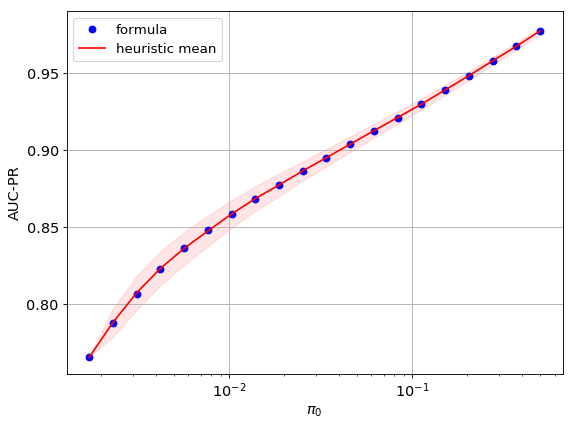

In [27]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pi0s,formula,'bo')
plt.plot(pi0s,heuristic_mean,'r')
plt.fill_between(pi0s,np.array(heuristic_mean)-np.array(heuristic_std),np.array(heuristic_mean)+np.array(heuristic_std),alpha=0.1,color="r")
plt.xscale('log')
plt.grid()
plt.xlabel(r'$\pi_0$')
plt.ylabel('AUC-PR')
plt.rcParams.update({'font.size': 12})
plt.legend(['formula','heuristic mean'])
plt.savefig("heuristic_vs_formula.pdf")

# Experiments on openml

## Experiments on the 600 datasets from openml

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [29]:
# selecting binary classification tasks from open with 10-fold crossvalidation
tasks = openml.tasks.list_tasks(task_type_id=1)
tasks = pd.DataFrame.from_dict(tasks, orient='index')
filtered_tasks = tasks.query('estimation_procedure == "10-fold Crossvalidation" and NumberOfClasses == 2')

In [30]:
print("Number of tasks :", len(filtered_tasks))

Number of tasks : 780


In [31]:
metrics = {}
metrics["AUC-PR"] = []
metrics["AUC-PR$_{\pi_0 \approx \pi}$"] = []
metrics["AUC-PR$_{\pi_0 = 0.5}$"] = []
metrics["AUC-PR Gain"] = []
metrics["AUC-PR Gain$_{\pi_0 \approx \pi}$"] = []
metrics["AUC-PR Gain$_{\pi_0 = 0.5}$"] = []
metrics["F1 score"] = []
metrics["F1 score$_{\pi_0 \approx \pi}$"] = []
metrics["F1 score$_{\pi_0 = 0.5}$"] = []
metrics["AUC-ROC"] = []

In [32]:
# for each open tasks, take up to 200 runs and sample 30 of them. Compute the averange metrics of the run on the 10 folds
for task_id in filtered_tasks.tid.values:
    print("Task : ", task_id)
    all_runs = openml.runs.list_runs(task=[task_id],size=200)
    if len(all_runs.keys()) < 30:
        print("Not enough runs")
    else:
        selected_runs = random.sample(list(all_runs), 30)
        current_metrics = {}
        for key in metrics:
            current_metrics[key] = np.zeros(30)
        try:
            for (iterator,run_key) in enumerate(selected_runs):
                
                print("Run : ", run_key)
                
                # getting predictions of current run
                
                curr_run = openml.runs.get_run(run_key)
                predictions_file_url = openml._api_calls._file_id_to_url(
                    curr_run.output_files['predictions'], 'predictions.arff',
                )
    
                predictions_arff = arff.loads(openml._api_calls._read_url(predictions_file_url,request_method='get'))
    
                
                attribute_names = [att[0] for att in predictions_arff['attributes']]
    
                attribute_dict = OrderedDict()
                for idx in range(len(attribute_names)):
                    attribute_dict[attribute_names[idx]] = idx
    
                if 'correct' in attribute_names:
                    correct_idx = attribute_dict['correct']
                else:
                    correct_idx = attribute_dict['truth']
    
                repeat_idx = attribute_dict['repeat']
    
                fold_idx = attribute_dict['fold']
    
                true_class = predictions_arff['attributes'][correct_idx][1][0]
                y_true_init = (np.array(predictions_arff.get('data'))[:,-1] == true_class)*1
                
                
                # computing pi
                
                pos_ratio = np.sum(y_true_init)/len(y_true_init)
                
                
                current_metric = {}
                
                for key in current_metrics:
                    current_metric[key] = 0
    
                if len(np.unique(y_true_init)) != 1:
                    
                    # if the positive class is larger than the negative class, flip the classes so that it becomes smaller
                    if pos_ratio > 0.5:
                        predicted_idx = attribute_dict['confidence.' + predictions_arff['attributes'][correct_idx][1][1]]
                    else:
                        predicted_idx = attribute_dict['confidence.' + predictions_arff['attributes'][correct_idx][1][0]]                                   
    
                    reps = np.array(predictions_arff.get('data'))[:,repeat_idx]
                    selec_rep = reps[0]
    
                    mask_rep = np.array(predictions_arff.get('data'))[:,repeat_idx] == selec_rep
                    
                    # if the positive class is larger than the negative class, flip the classes so that it becomes smaller
                    if pos_ratio > 0.5:
                        y_pred_rep = np.array(predictions_arff.get('data'))[mask_rep,predicted_idx].astype(float)
                        y_true_rep = (np.array(predictions_arff.get('data'))[mask_rep,correct_idx] != true_class)*1
                    else:
                        y_pred_rep = np.array(predictions_arff.get('data'))[mask_rep,predicted_idx].astype(float)
                        y_true_rep = (np.array(predictions_arff.get('data'))[mask_rep,correct_idx] == true_class)*1
                        
                    
                    
                    #iterate over the folds of the run
                    for n_fold in range(10):
                        mask = np.array(predictions_arff.get('data'))[mask_rep,fold_idx].astype(float) == n_fold
                        y_pred = y_pred_rep[mask]
                        y_true = y_true_rep[mask]
                        pos_ratio = np.sum(y_true)/len(y_true)
                        pi0close = pos_ratio*1.01
                        
                        current_metric["AUC-PR"] += average_precision(y_true,y_pred)
                        current_metric["AUC-PR$_{\pi_0 \approx \pi}$"] += average_precision(y_true,y_pred,pi0=pi0close)
                        current_metric["AUC-PR$_{\pi_0 = 0.5}$"] += average_precision(y_true,y_pred,pi0=0.5)
                        current_metric["AUC-PR Gain"] += prg.calc_auprg(prg.create_prg_curve(y_true,y_pred))
                        current_metric["AUC-PR Gain$_{\pi_0 \approx \pi}$"] += prgc.calc_auprg(prgc.create_prg_curve(y_true,y_pred,pi0=pi0close))
                        current_metric["AUC-PR Gain$_{\pi_0 = 0.5}$"] += prgc.calc_auprg(prgc.create_prg_curve(y_true,y_pred,pi0=0.5))
                        current_metric["F1 score"] += bestf1score(y_true,y_pred)
                        current_metric["F1 score$_{\pi_0 \approx \pi}$"] += bestf1score(y_true,y_pred,pi0=pi0close)
                        current_metric["F1 score$_{\pi_0 = 0.5}$"] += bestf1score(y_true,y_pred,pi0=0.5) 
                        current_metric["AUC-ROC"] += roc_auc_score(y_true,y_pred)
                
                
                for key in current_metrics:
                    current_metrics[key][iterator] = current_metric[key]/10
            for key in metrics:
                    metrics[key].append(current_metrics[key])
        except:
            print("Exception occured")

In [34]:
len(metrics['AUC-PR'])

602

In [35]:
from scipy.stats import spearmanr

In [36]:
correlation_matrix = np.zeros([len(metrics.keys()),len(metrics.keys())])
for exp in range(len(metrics.get("AUC-PR"))):
    for i,key1 in enumerate(metrics.keys()):
        for j,key2 in enumerate(metrics.keys()):
            if np.isnan(spearmanr(np.nan_to_num(metrics.get(key1)[exp]),np.nan_to_num(metrics.get(key2)[exp])).correlation):
                correlation_matrix[i,j] = correlation_matrix[i,j] + 1
            else:
                correlation_matrix[i,j] = correlation_matrix[i,j] + spearmanr(np.nan_to_num(metrics.get(key1)[exp]),np.nan_to_num(metrics.get(key2)[exp])).correlation

In [37]:
correlation_matrix_norm = correlation_matrix/len(metrics.get("AUC-PR"))

In [38]:
legend_matrix = ['AUC-PR', 'AUC-PR$_{\pi_0 ≈ \pi}$', 'AUC-PR$_{\pi_0 = 0.5}$', 'AUC-PR Gain', 'AUC-PR Gain$_{\pi_0 ≈ \pi}$', 'AUC-PR Gain$_{\pi_0 = 0.5}$', 'F1 score', 'F1 score$_{\pi_0 ≈ \pi}$', 'F1 score$_{\pi_0 = 0.5}$', 'AUC-ROC']

In [39]:
green_palette = sns.light_palette("green")

In [40]:
only_plot_bottom_matrix = False

In [41]:
if only_plot_bottom_matrix:
    mask = np.triu(np.ones_like(correlation_matrix_norm, dtype=np.bool))
    for i in range(mask.shape[0]):
        mask[i,i] = False
else:
    mask = np.ones(correlation_matrix_norm.shape) == 0

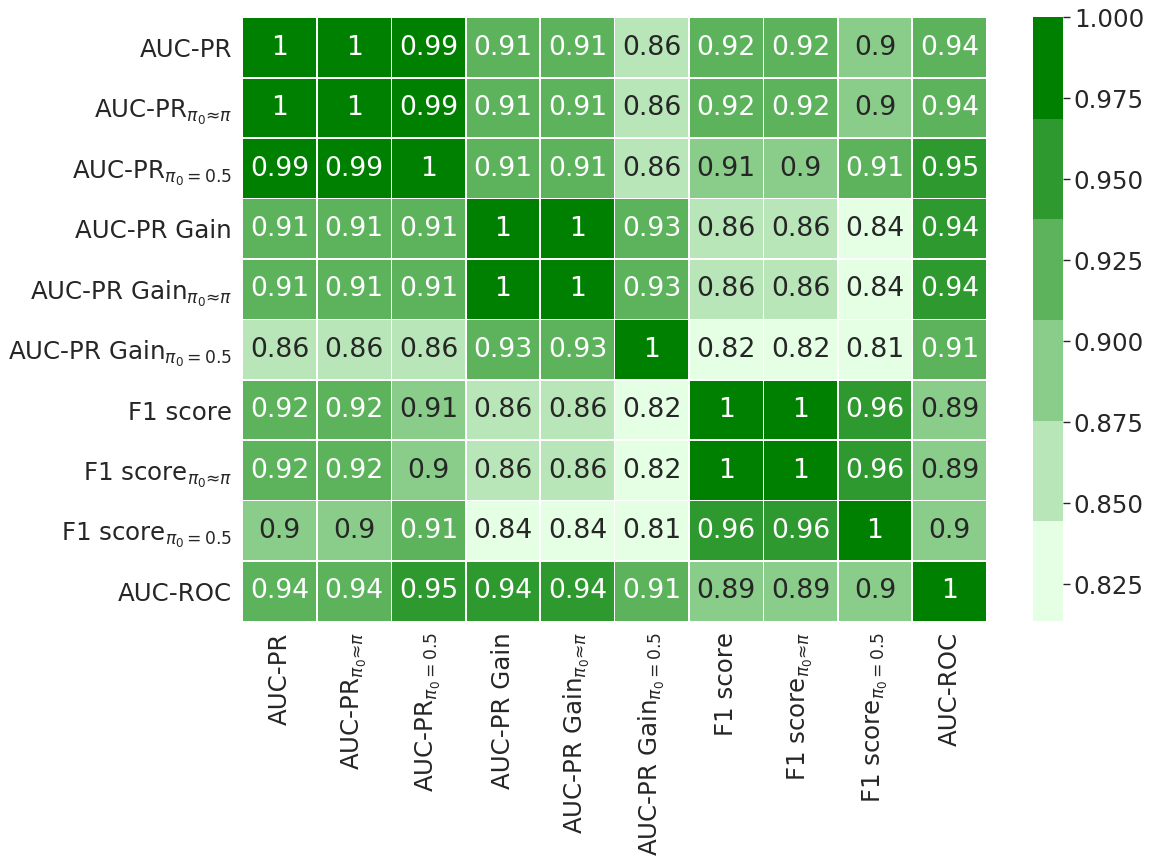

In [42]:
sns.set(font_scale=2)
plt.figure(num=None, figsize=(15,10), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(correlation_matrix_norm,mask = mask,annot=True, linewidth=0.5,xticklabels=legend_matrix,yticklabels=legend_matrix,cmap=green_palette)  
plt.show()
ax.figure.savefig("correlation_matrix_alldata.pdf",bbox_inches='tight')

In [ ]:
import pickle
with open('metrics_balanced.pkl','wb') as f:
    pickle.dump(metrics, f)

## Some stats on openml task's positive class ratio

In [43]:
openml_list = openml.datasets.list_datasets()
datalist = pd.DataFrame.from_dict(openml_list, orient='index')
datalist['pi'] = datalist['MinorityClassSize']/(datalist['MinorityClassSize']+datalist['MajorityClassSize'])
datalist = datalist[[
    'did', 'name', 'NumberOfInstances',
    'NumberOfFeatures', 'NumberOfClasses','pi'
]]
filtered_data = datalist.query('NumberOfClasses == 2 and pi != "NaN"')

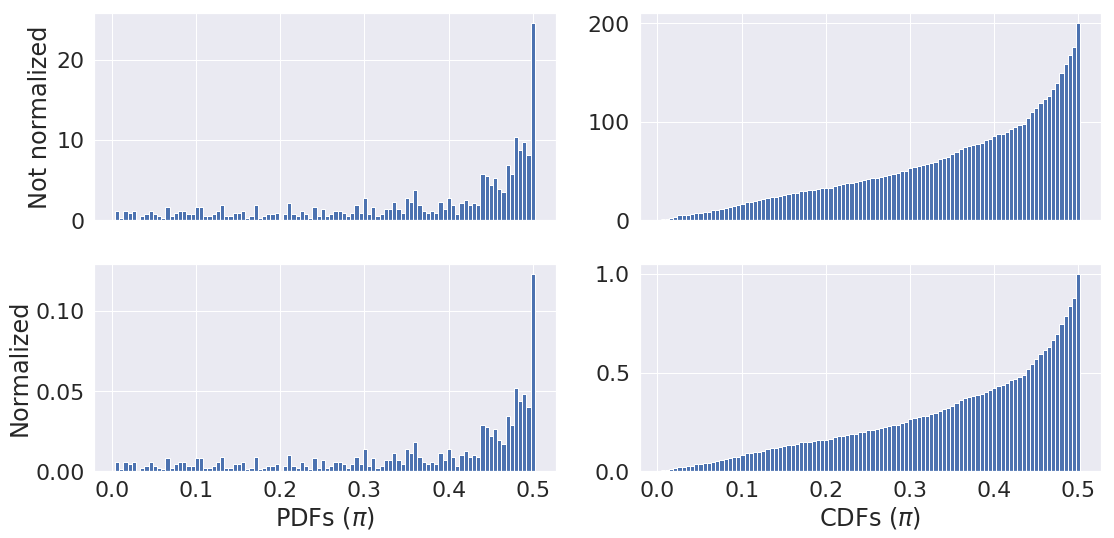

In [44]:
x = filtered_data["pi"].values
density, bins = np.histogram(x, normed=True, density=True,bins = 100)
unity_density = density / density.sum()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(16,8))
widths = bins[:-1] - bins[1:]
ax1.bar(bins[1:], density, width=widths)
ax2.bar(bins[1:], density.cumsum(), width=widths)

ax3.bar(bins[1:], unity_density, width=widths)
ax4.bar(bins[1:], unity_density.cumsum(), width=widths)

ax1.set_ylabel('Not normalized')
ax3.set_ylabel('Normalized')
ax3.set_xlabel('PDFs ($\pi$)')
ax4.set_xlabel('CDFs ($\pi$)')
fig.tight_layout()

In [ ]:
#plt.hist(filtered_data["pi"].values, normed=True, cumulative=True, label='CDF',bins=50,histtype='step', alpha=0.8, color='k')

## Experiments on the 4 extremely imbalanced datasets from openml

In [45]:
openml_list = openml.datasets.list_datasets()
datalist = pd.DataFrame.from_dict(openml_list, orient='index')
datalist['pi'] = datalist['MinorityClassSize']/(datalist['MinorityClassSize']+datalist['MajorityClassSize'])
datalist = datalist[[
    'did', 'name', 'NumberOfInstances',
    'NumberOfFeatures', 'NumberOfClasses','pi'
]]
filtered_data = datalist.query('pi < 0.01 and NumberOfClasses == 2')
data_ids = filtered_data["did"].values
print(len(filtered_data))
tasks = openml.tasks.list_tasks(task_type_id=1)
tasks = pd.DataFrame.from_dict(tasks, orient='index')

6


In [46]:
query = 'estimation_procedure == "10-fold Crossvalidation" and ('
for i, curr_id in enumerate(data_ids):
    if i == 0:
        query = query + 'did == ' + str(curr_id)
    else :
        query = query + ' or did == ' + str(curr_id)  
query = query + ')'

In [47]:
print(query)

estimation_procedure == "10-fold Crossvalidation" and (did == 1056 or did == 1069 or did == 1597 or did == 4154 or did == 42252 or did == 42256)


In [48]:
filtered_tasks = tasks.query(query)

In [49]:
filtered_tasks

,tid,ttid,did,name,task_type,status,estimation_procedure,evaluation_measures,source_data,target_feature,...,MaxNominalAttDistinctValues,MinorityClassSize,NumberOfClasses,NumberOfFeatures,NumberOfInstances,NumberOfInstancesWithMissingValues,NumberOfMissingValues,NumberOfNumericFeatures,NumberOfSymbolicFeatures,cost_matrix
3907,3907,1,1056,mc1,Supervised Classification,active,10-fold Crossvalidation,predictive_accuracy,1056,c,...,2.0,68.0,2.0,39.0,9466.0,0.0,0.0,38.0,1.0,NaN
3919,3919,1,1069,pc2,Supervised Classification,active,10-fold Crossvalidation,predictive_accuracy,1069,c,...,2.0,23.0,2.0,37.0,5589.0,0.0,0.0,36.0,1.0,NaN
7608,7608,1,1597,creditcard,Supervised Classification,active,10-fold Crossvalidation,NaN,1597,Class,...,2.0,492.0,2.0,31.0,284807.0,0.0,0.0,30.0,1.0,NaN
9912,9912,1,1597,creditcard,Supervised Classification,active,10-fold Crossvalidation,area_under_roc_curve,1597,Class,...,2.0,492.0,2.0,31.0,284807.0,0.0,0.0,30.0,1.0,"[[0,1],[500,0]]"
10105,10105,1,1597,creditcard,Supervised Classification,active,10-fold Crossvalidation,usercpu_time_millis,1597,Class,...,2.0,492.0,2.0,31.0,284807.0,0.0,0.0,30.0,1.0,"[[0,1],[500,0]]"
10106,10106,1,4154,CreditCardSubset,Supervised Classification,active,10-fold Crossvalidation,area_under_roc_curve,4154,Class,...,2.0,23.0,2.0,31.0,14240.0,0.0,0.0,30.0,1.0,"[[0,1],[500,0]]"
145684,145684,1,1597,creditcard,Supervised Classification,active,10-fold Crossvalidation,area_under_roc_curve,1597,Class,...,2.0,492.0,2.0,31.0,284807.0,0.0,0.0,30.0,1.0,NaN
145685,145685,1,1597,creditcard,Supervised Classification,active,10-fold Crossvalidation,total_cost,1597,Class,...,2.0,492.0,2.0,31.0,284807.0,0.0,0.0,30.0,1.0,"[[0,1],[500,0]]"
145934,145934,1,4154,CreditCardSubset,Supervised Classification,active,10-fold Crossvalidation,NaN,4154,Class,...,2.0,23.0,2.0,31.0,14240.0,0.0,0.0,30.0,1.0,NaN
211687,211687,1,42252,Asteroid_Dataset,Supervised Classification,active,10-fold Crossvalidation,predictive_accuracy,42252,pha,...,NaN,156.0,2.0,34.0,126131.0,96.0,99.0,31.0,2.0,NaN


In [50]:
metrics_imb = {}
metrics_imb["AUC-PR"] = []
metrics_imb["AUC-PR$_{\pi_0 \approx \pi}$"] = []
metrics_imb["AUC-PR$_{\pi_0 = 0.5}$"] = []
metrics_imb["AUC-PR Gain"] = []
metrics_imb["AUC-PR Gain$_{\pi_0 \approx \pi}$"] = []
metrics_imb["AUC-PR Gain$_{\pi_0 = 0.5}$"] = []
metrics_imb["F1 score"] = []
metrics_imb["F1 score$_{\pi_0 \approx \pi}$"] = []
metrics_imb["F1 score$_{\pi_0 = 0.5}$"] = []
metrics_imb["AUC-ROC"] = []

In [51]:
# for each open tasks, take up to 200 runs and sample 30 of them. Compute the averange metrics of the run on the 10 folds
for task_id in filtered_tasks.tid.values:
    print("Task : ", task_id)
    all_runs = openml.runs.list_runs(task=[task_id],size=200)
    if len(all_runs.keys()) < 30:
        print("Not enough runs")
    else:
        selected_runs = random.sample(list(all_runs), 30)
        current_metrics = {}
        for key in metrics_imb:
            current_metrics[key] = np.zeros(30)
        try:
            for (iterator,run_key) in enumerate(selected_runs):
                
                print("Run : ", run_key)
                
                # getting predictions of current run
                
                curr_run = openml.runs.get_run(run_key)
                predictions_file_url = openml._api_calls._file_id_to_url(
                    curr_run.output_files['predictions'], 'predictions.arff',
                )
    
                predictions_arff = arff.loads(openml._api_calls._read_url(predictions_file_url,request_method='get'))
    
                
                attribute_names = [att[0] for att in predictions_arff['attributes']]
    
                attribute_dict = OrderedDict()
                for idx in range(len(attribute_names)):
                    attribute_dict[attribute_names[idx]] = idx
    
                if 'correct' in attribute_names:
                    correct_idx = attribute_dict['correct']
                else:
                    correct_idx = attribute_dict['truth']
    
                repeat_idx = attribute_dict['repeat']
    
                fold_idx = attribute_dict['fold']
    
                true_class = predictions_arff['attributes'][correct_idx][1][0]
                y_true_init = (np.array(predictions_arff.get('data'))[:,-1] == true_class)*1
                
                
                # computing pi
                
                pos_ratio = np.sum(y_true_init)/len(y_true_init)
                
                
                current_metric = {}
                
                for key in current_metrics:
                    current_metric[key] = 0
    
                if len(np.unique(y_true_init)) != 1:
                    
                    # if the positive class is larger than the negative class, flip the classes so that it becomes smaller
                    if pos_ratio > 0.5:
                        predicted_idx = attribute_dict['confidence.' + predictions_arff['attributes'][correct_idx][1][1]]
                    else:
                        predicted_idx = attribute_dict['confidence.' + predictions_arff['attributes'][correct_idx][1][0]]                                   
    
                    reps = np.array(predictions_arff.get('data'))[:,repeat_idx]
                    selec_rep = reps[0]
    
                    mask_rep = np.array(predictions_arff.get('data'))[:,repeat_idx] == selec_rep
                    
                    # if the positive class is larger than the negative class, flip the classes so that it becomes smaller
                    if pos_ratio > 0.5:
                        y_pred_rep = np.array(predictions_arff.get('data'))[mask_rep,predicted_idx].astype(float)
                        y_true_rep = (np.array(predictions_arff.get('data'))[mask_rep,correct_idx] != true_class)*1
                    else:
                        y_pred_rep = np.array(predictions_arff.get('data'))[mask_rep,predicted_idx].astype(float)
                        y_true_rep = (np.array(predictions_arff.get('data'))[mask_rep,correct_idx] == true_class)*1
                        
                    
                    
                    #iterate over the folds of the run
                    for n_fold in range(10):
                        mask = np.array(predictions_arff.get('data'))[mask_rep,fold_idx].astype(float) == n_fold
                        y_pred = y_pred_rep[mask]
                        y_true = y_true_rep[mask]
                        pos_ratio = np.sum(y_true)/len(y_true)
                        pi0close = pos_ratio*10
                        
                        current_metric["AUC-PR"] += average_precision(y_true,y_pred)
                        current_metric["AUC-PR$_{\pi_0 \approx \pi}$"] += average_precision(y_true,y_pred,pi0=pi0close)
                        current_metric["AUC-PR$_{\pi_0 = 0.5}$"] += average_precision(y_true,y_pred,pi0=0.5)
                        current_metric["AUC-PR Gain"] += prg.calc_auprg(prg.create_prg_curve(y_true,y_pred))
                        current_metric["AUC-PR Gain$_{\pi_0 \approx \pi}$"] += prgc.calc_auprg(prgc.create_prg_curve(y_true,y_pred,pi0=pi0close))
                        current_metric["AUC-PR Gain$_{\pi_0 = 0.5}$"] += prgc.calc_auprg(prgc.create_prg_curve(y_true,y_pred,pi0=0.5))
                        current_metric["F1 score"] += bestf1score(y_true,y_pred)
                        current_metric["F1 score$_{\pi_0 \approx \pi}$"] += bestf1score(y_true,y_pred,pi0=pi0close)
                        current_metric["F1 score$_{\pi_0 = 0.5}$"] += bestf1score(y_true,y_pred,pi0=0.5) 
                        current_metric["AUC-ROC"] += roc_auc_score(y_true,y_pred)
                
                
                for key in current_metrics:
                    current_metrics[key][iterator] = current_metric[key]/10
            for key in metrics_imb:
                    metrics_imb[key].append(current_metrics[key])
        except:
            print("Exception occured")

In [53]:
correlation_matrix_imb = np.zeros([len(metrics_imb.keys()),len(metrics_imb.keys())])
for exp in range(len(metrics_imb.get("AUC-PR"))):
    for i,key1 in enumerate(metrics_imb.keys()):
        for j,key2 in enumerate(metrics_imb.keys()):
            if np.isnan(spearmanr(np.nan_to_num(metrics_imb.get(key1)[exp]),np.nan_to_num(metrics_imb.get(key2)[exp])).correlation):
                correlation_matrix_imb[i,j] = correlation_matrix_imb[i,j] + 1
            else:
                correlation_matrix_imb[i,j] = correlation_matrix_imb[i,j] + spearmanr(np.nan_to_num(metrics_imb.get(key1)[exp]),np.nan_to_num(metrics_imb.get(key2)[exp])).correlation

In [54]:
correlation_matrix_imb_norm = correlation_matrix_imb/len(metrics_imb.get("AUC-PR"))

In [55]:
legend_matrix = ['AUC-PR', 'AUC-PR$_{\pi_0 ≈ \pi}$', 'AUC-PR$_{\pi_0 = 0.5}$', 'AUC-PR Gain', 'AUC-PR Gain$_{\pi_0 ≈ \pi}$', 'AUC-PR Gain$_{\pi_0 = 0.5}$', 'F1 score', 'F1 score$_{\pi_0 ≈ \pi}$', 'F1 score$_{\pi_0 = 0.5}$', 'AUC-ROC']

In [56]:
blue_palette = sns.light_palette("blue")

In [57]:
mask = np.triu(np.ones_like(correlation_matrix_imb_norm, dtype=np.bool))

In [58]:
if only_plot_bottom_matrix:
    mask = np.triu(np.ones_like(correlation_matrix_imb_norm, dtype=np.bool))
    for i in range(mask.shape[0]):
        mask[i,i] = False
else:
    mask = np.ones(correlation_matrix_norm.shape) == 0

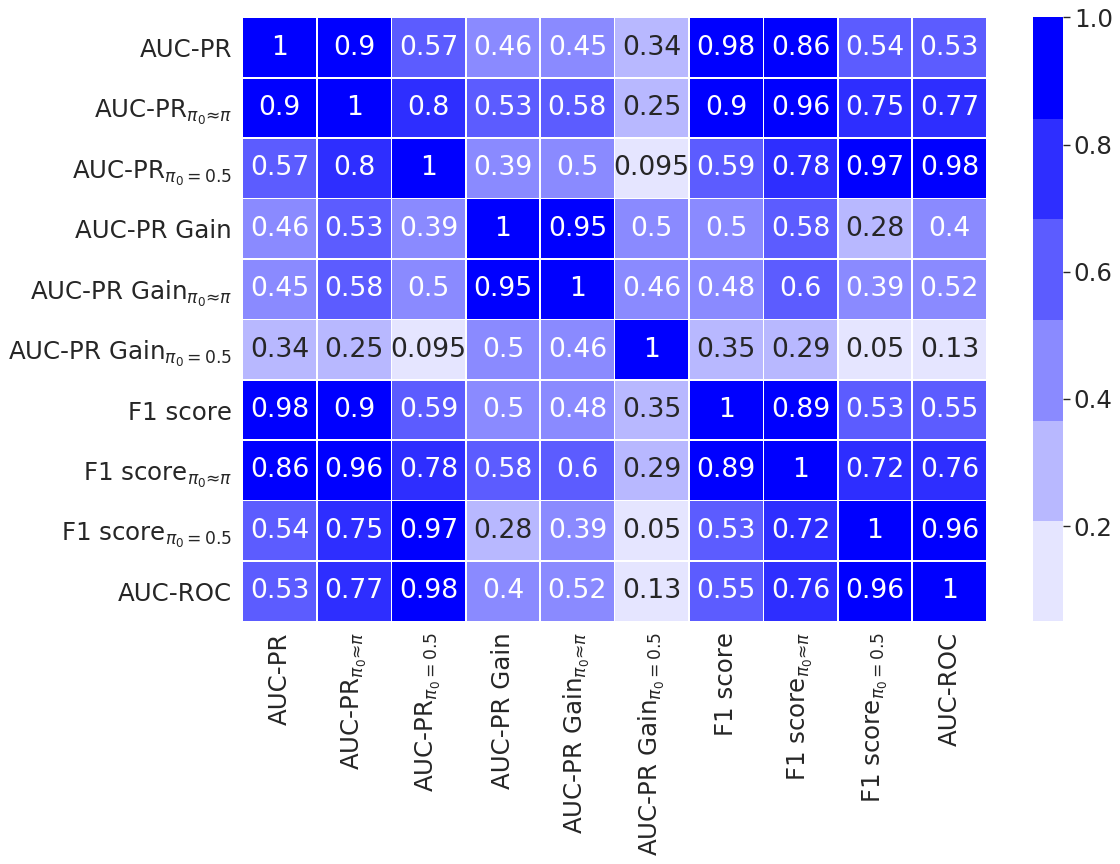

In [59]:
sns.set(font_scale=2)
plt.figure(num=None, figsize=(15,10), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(correlation_matrix_imb_norm,mask=mask,annot=True, linewidth=0.5,xticklabels=legend_matrix,yticklabels=legend_matrix,cmap=blue_palette)
plt.show()
ax.figure.savefig("correlation_matrix_imbalanced.pdf",bbox_inches='tight')

In [ ]:
import pickle
with open('metrics_imbalanced.pkl','wb') as f:
    pickle.dump(metrics_imb, f)